In [ ]:
import yfinance as yf
import pandas as pd
import plotly.express as px

# Define the tickers
tickers = {
    'Bitcoin': 'btc-USD',
}

# Download historical data for the tickers
data = yf.download(
    tickers=list(tickers.values()),
    period='max',       # Adjust the period as needed # Adjust the period as needed '6mo' '1d' 'max'
    interval='1d',     # Data interval Data interval '1m' '1h' '1d'       #best is w max and 1d so far 
    group_by='ticker',
    auto_adjust=True,
    threads=True
)

print(data)

btc = data


#Only for my pc

#Flattening the multi-level columns
btc.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in btc.columns]

# Renaming the columns to remove prefixes and simplify names
new_column_names = {
    'Date': 'Date',
    'BTC-USD_Open': 'Open',
    'BTC-USD_High': 'High',
    'BTC-USD_Low': 'Low',
    'BTC-USD_Close': 'Close',
    'BTC-USD_Volume': 'Volume'
}
btc.rename(columns=new_column_names, inplace=True)

# Reset the index, which moves the date from the index to a column
btc.reset_index(inplace=True)

# Step 1: Extract Bitcoin Volume before dropping columns
print(btc['Volume'].eq(0).sum())
print(btc)
print(btc.describe())
na_counts = btc.isna().sum()

# Display the count of NaNs for each column
print(na_counts)


[*********************100%***********************]  1 of 1 completed

Ticker                           BTC-USD                               \
Price                               Open           High           Low   
Date                                                                    
2014-09-17 00:00:00+00:00     465.864014     468.174011    452.421997   
2014-09-18 00:00:00+00:00     456.859985     456.859985    413.104004   
2014-09-19 00:00:00+00:00     424.102997     427.834991    384.532013   
2014-09-20 00:00:00+00:00     394.673004     423.295990    389.882996   
2014-09-21 00:00:00+00:00     408.084991     412.425995    393.181000   
...                                  ...            ...           ...   
2024-12-06 00:00:00+00:00   97074.226562  102039.882812  96514.875000   
2024-12-07 00:00:00+00:00   99916.710938  100563.382812  99030.882812   
2024-12-08 00:00:00+00:00   99921.914062  101399.992188  98771.515625   
2024-12-09 00:00:00+00:00  101237.062500  101272.507812  94355.914062   
2024-12-10 00:00:00+00:00   97391.328125   98220.03

In [ ]:
if 'Datetime' in btc.columns:
    btc.rename(columns={'Datetime': 'Date'}, inplace=True)
    btc = btc.drop(columns="Volume")

print(btc)

# Perform min-max normalization for each asset
normalized_prices = btc.copy()

# Exclude the 'Date' column during normalization
for col in normalized_prices.columns[1:]:
    min_price = normalized_prices[col].min()
    max_price = normalized_prices[col].max()
    normalized_prices[col] = ((normalized_prices[col] - min_price) / (max_price - min_price)) * 100

# Melt the DataFrame to long format
normalized_prices_melted = normalized_prices.melt(id_vars='Date', var_name='Asset', value_name='Normalized Price')

import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each asset's normalized prices
for asset, data in normalized_prices_melted.groupby('Asset'):
    ax.plot(data['Date'], data['Normalized Price'], label=asset)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Price (0% = Min, 100% = Max)')
ax.set_title('Min-Max Normalized Closing Prices for Selected Assets Over Time')
ax.legend()

# Show the plot
plt.show()

btc.rename(columns={'Close': 'Bitcoin Close'}, inplace=True)
print(btc)

In [ ]:
import pandas as pd
import os

def clean_sentiment_score(score):
    """Remove leading single quote from sentiment score if present"""
    if isinstance(score, str) and score.startswith("'"):
        return float(score.lstrip("'"))
    return float(score)

# Read the sentiment file
file_path = os.path.join(os.path.expanduser('~'), 'Downloads', 'combined_crypto_analysis.csv')
sentiment_df = pd.read_csv(file_path)

# Process and merge the data
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date']).dt.tz_localize('UTC')
sentiment_df['sentiment_score'] = sentiment_df['avg_sentiment'].apply(clean_sentiment_score)
btc['Date'] = pd.to_datetime(btc['Date'])

# Merge and update btc DataFrame
btc = btc.merge(sentiment_df[['Date', 'sentiment_score']], on='Date', how='left')

print(f"Merged shape: {btc.shape}, Rows with sentiment: {btc['sentiment_score'].notna().sum()}")

btc
              Open          High           Low  Bitcoin Close       Volume  \
0       456.859985    456.859985    413.104004      -7.192558     34483200   
1       424.102997    427.834991    384.532013      -6.984265     37919700   
2       394.673004    423.295990    389.882996       3.573492     36863600   
3       408.084991    412.425995    393.181000      -2.465854     26580100   
4       399.100006    406.915985    397.130005       0.835210     24127600   
...            ...           ...           ...            ...          ...   
3723  91978.140625  97361.179688  91778.664062       4.323745  71133452438   
3724  95954.945312  96650.203125  94677.351562      -0.323108  52260008261   
3725  95653.953125  98693.171875  95407.882812       1.891279  54968682476   
3726  97468.812500  97499.343750  96144.218750      -1.038839  31634227866   
3727  96461.335938  97888.125000  95770.187500       0.861319  36590695296   

      sentiment_score         Close  
0           -2.274216

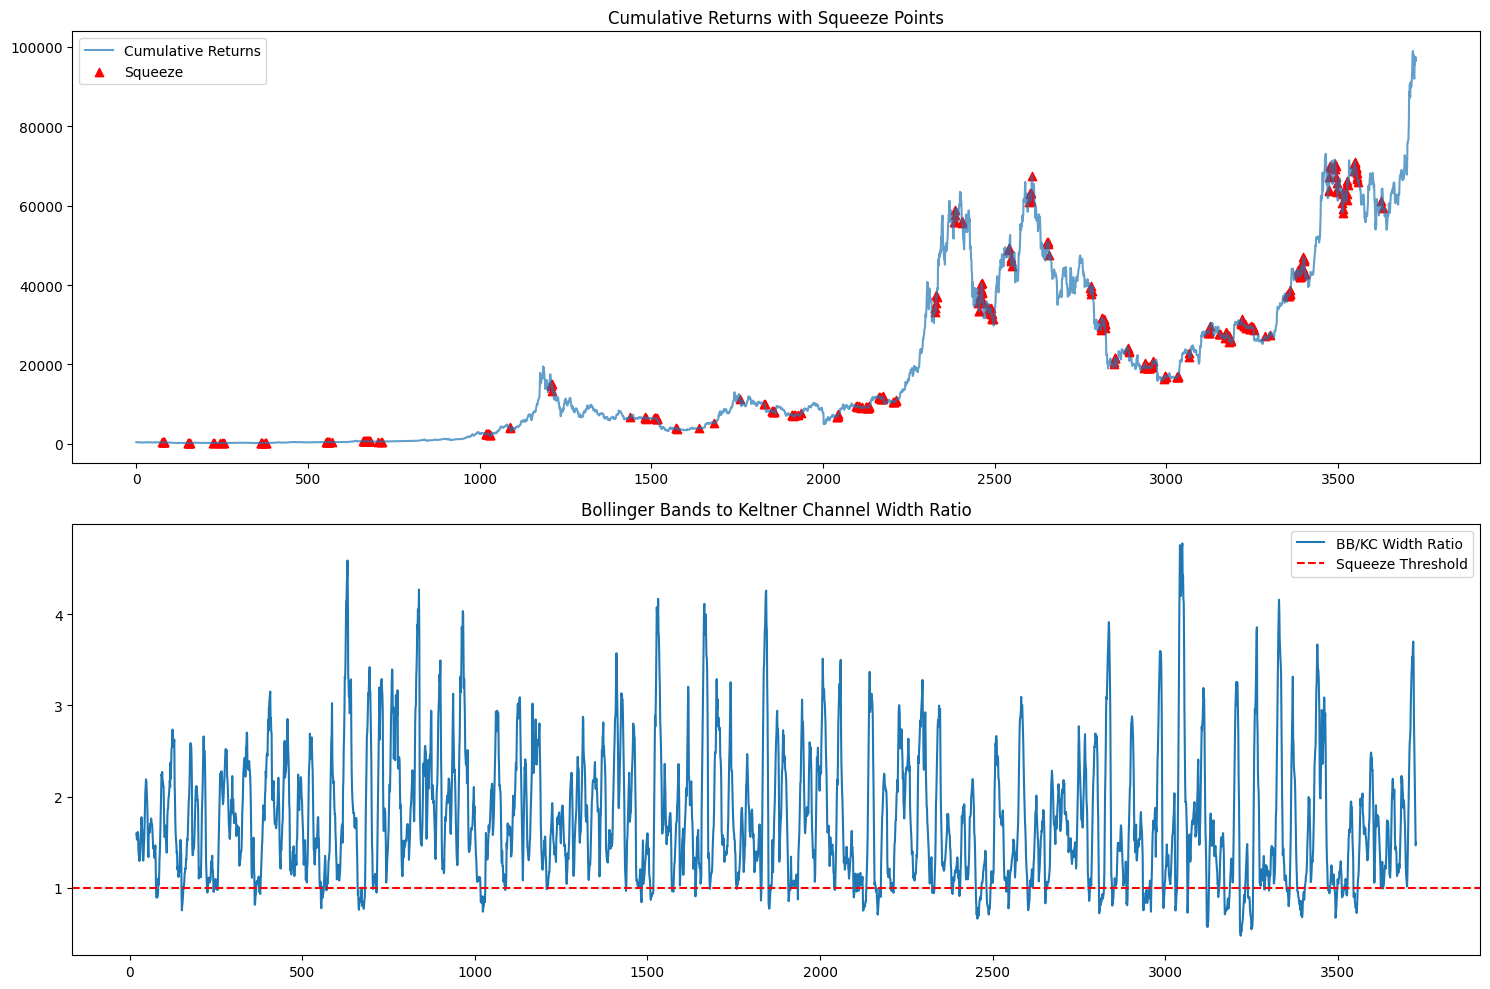

count     3709.000000
mean      4297.664753
std       5582.674845
min         10.679233
25%        319.551435
50%       2065.746485
75%       6488.964456
max      39268.288731
Name: BB_width, dtype: float64
count     3709.000000
mean      2609.823380
std       3135.504471
min          9.846689
25%        187.898466
50%       1155.763658
75%       4109.488691
max      16079.761631
Name: KC_width, dtype: float64
count    3709.000000
mean        1.754004
std         0.721469
min         0.473087
25%         1.187568
50%         1.606496
75%         2.174062
max         4.776663
Name: BB_KC_ratio, dtype: float64
First few values of cumulative_returns:
3723    95962.531250
3724    95652.468750
3725    97461.523438
3726    96449.054688
3727    97279.789062
Name: Close, dtype: float64
First few values of cumulative_high:
3723    97361.179688
3724    96650.203125
3725    98693.171875
3726    97499.343750
3727    97888.125000
Name: High, dtype: float64
First few values of cumulative_low:
3723  

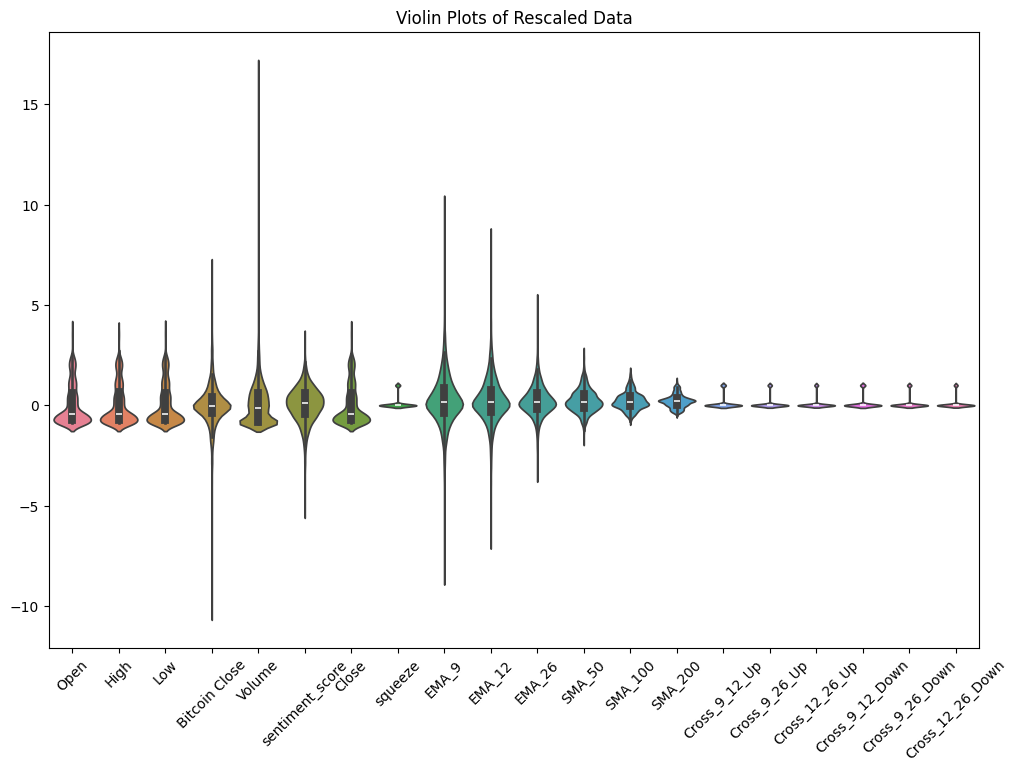

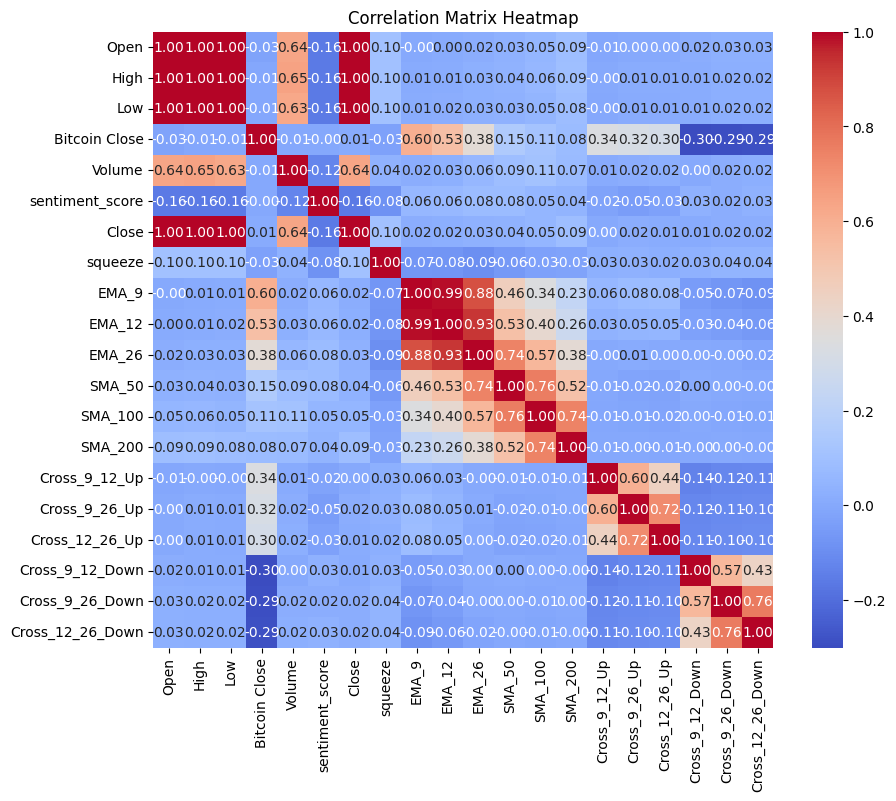

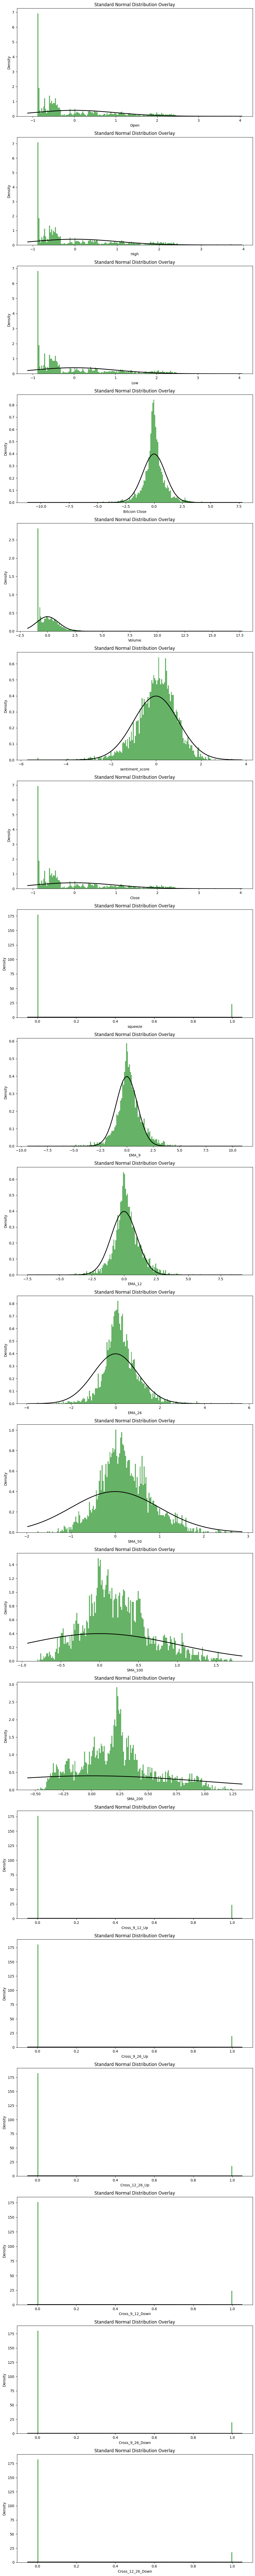

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Converts Close to Percentage ################################################################################
btc["Close"] = btc['Bitcoin Close']
btc['Bitcoin Close'] = btc['Bitcoin Close'].pct_change() * 100
btc = btc.dropna().reset_index(drop=True)

#rescaled_data.dropna(inplace=True) 

def global_rescale(data):
    mean_val = np.mean(data)
    std_val = np.std(data)
    # Avoid division by zero if data has zero variance
    if std_val == 0:
        rescaled_data = np.zeros_like(data)
    else:
        rescaled_data = (data - mean_val) / std_val
    return rescaled_data

if 'Date' in btc.columns:
    btc = btc.drop(columns='Date')
# Apply the global_rescale function to each column
rescaled_data = btc.apply(global_rescale) 

print("btc")
print(btc)
print("rescaled_data")
print(rescaled_data)

# Calculate EMA for ATR
def calculate_ema(series, length):
    return series.ewm(span=length, adjust=False).mean()

# Parameters
bb_length = 20
bb_std_dev = 2
kc_length = 20
kc_multiplier = 1.5

# Convert percentage changes back to price-like series for calculations
cumulative_returns = btc['Close']
cumulative_high = btc['High']
cumulative_low = btc['Low']

# Calculate Bollinger Bands on the cumulative series
sma = cumulative_returns.rolling(window=bb_length).mean()
std = cumulative_returns.rolling(window=bb_length).std()
bb_upper = sma + (bb_std_dev * std)
bb_lower = sma - (bb_std_dev * std)

# Calculate True Range using cumulative values
tr1 = cumulative_high - cumulative_low
tr2 = abs(cumulative_high - cumulative_returns.shift(1))
tr3 = abs(cumulative_low - cumulative_returns.shift(1))
true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

# Calculate ATR using EMA
atr = calculate_ema(true_range, kc_length)

# Calculate Keltner Channels
kc_upper = sma + (kc_multiplier * atr)
kc_lower = sma - (kc_multiplier * atr)

# Calculate TTM Squeeze
squeeze = np.where(
    (bb_upper < kc_upper) & (bb_lower > kc_lower),
    1,  # Squeeze is on
    0   # Squeeze is off
)

# Calculate Momentum
highest_high = cumulative_high.rolling(window=bb_length).max()
lowest_low = cumulative_low.rolling(window=bb_length).min()
avg_hl = (highest_high + lowest_low) / 2
avg_hlc = (avg_hl + cumulative_returns) / 2
momentum = cumulative_returns - avg_hlc

# Store calculations
btc['squeeze'] = squeeze
rescaled_data['squeeze'] = squeeze
btc['momentum'] = momentum
btc['BB_upper'] = bb_upper
btc['BB_lower'] = bb_lower
btc['KC_upper'] = kc_upper
btc['KC_lower'] = kc_lower
btc['BB_width'] = bb_upper - bb_lower
btc['KC_width'] = kc_upper - kc_lower
btc['BB_KC_ratio'] = (bb_upper - bb_lower) / (kc_upper - kc_lower)

# Print statistics
print("\nBand Width Statistics:")
print("\nBollinger Band Width:")
print(btc['BB_width'].describe())
print("\nKeltner Channel Width:")
print(btc['KC_width'].describe())
print("\nSqueeze Statistics:")
print(f"Total periods: {len(btc)}")
print(f"Number of squeeze periods: {btc['squeeze'].sum()}")
print(f"Percentage of time in squeeze: {(btc['squeeze'].sum() / len(btc) * 100):.2f}%")

# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Price with squeeze points
plt.subplot(2, 1, 1)
plt.plot(btc.index, cumulative_returns, label='Cumulative Returns', alpha=0.7)
squeeze_points = btc[btc['squeeze'] == 1].index
plt.scatter(squeeze_points, 
           cumulative_returns[squeeze_points],
           color='red', marker='^', label='Squeeze')
plt.title('Cumulative Returns with Squeeze Points')
plt.legend()

# Plot 2: BB/KC Width Ratio
plt.subplot(2, 1, 2)
plt.plot(btc.index, btc['BB_KC_ratio'], label='BB/KC Width Ratio')
plt.axhline(y=1, color='r', linestyle='--', label='Squeeze Threshold')
plt.title('Bollinger Bands to Keltner Channel Width Ratio')
plt.legend()

plt.tight_layout()
plt.show()

print(btc['BB_width'].describe())
print(btc['KC_width'].describe())
print(btc['BB_KC_ratio'].describe())

# Print initial values to check scales and consistency
print("First few values of cumulative_returns:")
print(cumulative_returns.tail())

print("First few values of cumulative_high:")
print(cumulative_high.tail())

print("First few values of cumulative_low:")
print(cumulative_low.tail())

# After calculating True Range and ATR
print("\nFirst few values of True Range (TR):")
print(tr1.tail(), tr2.tail(), tr3.tail())

print("\nFirst few values of Average True Range (ATR):")
print(atr.tail())

# After calculating Bollinger Bands
print("\nFirst few values of SMA for Bollinger Bands:")
print(sma.tail())

print("\nFirst few values of Bollinger Bands Upper and Lower:")
print("BB Upper:", bb_upper.tail())
print("BB Lower:", bb_lower.tail())

# After calculating Keltner Channels
print("\nFirst few values of Keltner Channels Upper and Lower:")
print("KC Upper:", kc_upper.tail())
print("KC Lower:", kc_lower.tail())

# After calculating Widths
print("\nBollinger Band Width:")
print(btc['BB_width'].tail())

print("\nKeltner Channel Width:")
print(btc['KC_width'].tail())

# Print ratios and squeeze information
print("\nFirst few values of BB/KC Width Ratio:")
print(btc['BB_KC_ratio'].tail())

print("\nSqueeze Statistics:")
print("First few periods of squeeze signal:")
print(btc['squeeze'].tail())


btc.drop(columns=['Close'], inplace=True)

# Calculate EMAs and SMAs on the raw price data
price_emas = {
    'EMA_9': btc['Bitcoin Close'].ewm(span=9, adjust=False).mean(),
    'EMA_12': btc['Bitcoin Close'].ewm(span=12, adjust=False).mean(),
    'EMA_26': btc['Bitcoin Close'].ewm(span=26, adjust=False).mean(),
    'SMA_50': btc['Bitcoin Close'].rolling(window=50).mean(),
    'SMA_100': btc['Bitcoin Close'].rolling(window=100).mean(),
    'SMA_200': btc['Bitcoin Close'].rolling(window=200).mean()
}

# Calculate percentage-based EMAs and SMAs
rescaled_data['EMA_9'] = btc['Bitcoin Close'].ewm(span=9, adjust=False).mean()
rescaled_data['EMA_12'] = btc['Bitcoin Close'].ewm(span=12, adjust=False).mean()
rescaled_data['EMA_26'] = btc['Bitcoin Close'].ewm(span=26, adjust=False).mean()
rescaled_data['SMA_50'] = btc['Bitcoin Close'].rolling(window=50).mean()
rescaled_data['SMA_100'] = btc['Bitcoin Close'].rolling(window=100).mean()
rescaled_data['SMA_200'] = btc['Bitcoin Close'].rolling(window=200).mean()

# Detect upward crossovers
rescaled_data['Cross_9_12_Up'] = ((rescaled_data['EMA_9'] > rescaled_data['EMA_12']) & (rescaled_data['EMA_9'].shift(1) <= rescaled_data['EMA_12'].shift(1))).astype(int)
rescaled_data['Cross_9_26_Up'] = ((rescaled_data['EMA_9'] > rescaled_data['EMA_26']) & (rescaled_data['EMA_9'].shift(1) <= rescaled_data['EMA_26'].shift(1))).astype(int)
rescaled_data['Cross_12_26_Up'] = ((rescaled_data['EMA_12'] > rescaled_data['EMA_26']) & (rescaled_data['EMA_12'].shift(1) <= rescaled_data['EMA_26'].shift(1))).astype(int)

# Detect downward crossovers
rescaled_data['Cross_9_12_Down'] = ((rescaled_data['EMA_9'] < rescaled_data['EMA_12']) & (rescaled_data['EMA_9'].shift(1) >= rescaled_data['EMA_12'].shift(1))).astype(int)
rescaled_data['Cross_9_26_Down'] = ((rescaled_data['EMA_9'] < rescaled_data['EMA_26']) & (rescaled_data['EMA_9'].shift(1) >= rescaled_data['EMA_26'].shift(1))).astype(int)
rescaled_data['Cross_12_26_Down'] = ((rescaled_data['EMA_12'] < rescaled_data['EMA_26']) & (rescaled_data['EMA_12'].shift(1) >= rescaled_data['EMA_26'].shift(1))).astype(int)

# Drop all NaN values and reset index
rescaled_data.dropna(inplace=True)
rescaled_data.reset_index(drop=True, inplace=True)

print("Rescaled Data:")
print(rescaled_data)

# Compute basic statistics for each column
stats = rescaled_data.describe()

# Print the statistics
print("\nBasic Statistical Summary:")
print(stats)

# Plot violin plots for each column
plt.figure(figsize=(12, 8))
sns.violinplot(data=rescaled_data)
plt.title('Violin Plots of Rescaled Data')
plt.xticks(rotation=45)
plt.show()

# Compute the correlation matrix
corr_matrix = rescaled_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Plot histograms with a standard normal distribution overlay for each column
fig, axes = plt.subplots(nrows=len(rescaled_data.columns), ncols=1, figsize=(10, 5 * len(rescaled_data.columns)))
if len(rescaled_data.columns) == 1:
    axes = [axes]  # Ensure axes is iterable for a single-column dataframe

for ax, column in zip(axes, rescaled_data.columns):
    data = rescaled_data[column].dropna()  # Drop NA values

    # Define the number of bins to make them smaller
    bins = 200

    # Plot histogram
    ax.hist(data, bins=bins, density=True, alpha=0.6, color='g')
    
    # Define the range of x values for the normal distribution line
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    
    # Calculate the standard normal distribution
    p = norm.pdf(x, 0, 1)  # Mean = 0, Std = 1
    ax.plot(x, p, 'k', linewidth=2)
    
    ax.set_title(f"Standard Normal Distribution Overlay")
    ax.set_xlabel(column)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, classification_report
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, LRScheduler, Callback
from skorch.dataset import Dataset
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# First, create the train-test split (keeping the most recent data for testing)
test_size = 0.2
val_size = 0.2  
eval_size = 0.1 

# Calculate split indices
total_size = len(rescaled_data)
test_split_idx = int(total_size * (1 - test_size))
val_split_idx = int(test_split_idx * (1 - val_size - eval_size))
eval_split_idx = int(test_split_idx * (1 - eval_size))

# Split the data
X_train = rescaled_data.iloc[:val_split_idx, :]
X_eval = rescaled_data.iloc[val_split_idx:eval_split_idx, :]
X_val = rescaled_data.iloc[eval_split_idx:test_split_idx, :]
X_test = rescaled_data.iloc[test_split_idx:, :]

y_train = rescaled_data['Bitcoin Close'][:val_split_idx]
y_eval = rescaled_data['Bitcoin Close'][val_split_idx:eval_split_idx]
y_val = rescaled_data['Bitcoin Close'][eval_split_idx:test_split_idx]
y_test = rescaled_data['Bitcoin Close'][test_split_idx:]

def create_sequences(data, target, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:(i + seq_length)].to_numpy())
        y.append(target.iloc[i + seq_length])
    return np.array(X), np.array(y)

# Create sequences for all splits
seq_length = 10
X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
X_eval_seq, y_eval_seq = create_sequences(X_eval, y_eval, seq_length)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

# Convert to torch tensors
X_train_seq = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_seq = torch.tensor(y_train_seq, dtype=torch.float32).reshape(-1, 1)
X_eval_seq = torch.tensor(X_eval_seq, dtype=torch.float32)
y_eval_seq = torch.tensor(y_eval_seq, dtype=torch.float32).reshape(-1, 1)
X_val_seq = torch.tensor(X_val_seq, dtype=torch.float32)
y_val_seq = torch.tensor(y_val_seq, dtype=torch.float32).reshape(-1, 1)
X_test_seq = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_seq = torch.tensor(y_test_seq, dtype=torch.float32).reshape(-1, 1)

# Combine training and evaluation sets
X_combined = torch.cat([X_train_seq, X_eval_seq])
y_combined = torch.cat([y_train_seq, y_eval_seq])

# Create proper skorch Dataset
train_dataset = Dataset(X_combined, y_combined)

class PrintLossCallback(Callback):
    def on_epoch_end(self, net, dataset_train=None, dataset_valid=None, **kwargs):
        train_loss = net.history[-1, 'train_loss']
        valid_loss = net.history[-1, 'valid_loss']
        epoch = len(net.history)
        print(f'Epoch: {epoch:4d} | Train Loss: {train_loss:.6f} | Valid Loss: {valid_loss:.6f}')

class GradientClippingCallback(Callback):
    def __init__(self, clip_value=1.0):
        self.clip_value = clip_value

    def on_batch_end(self, net, **kwargs):
        torch.nn.utils.clip_grad_norm_(net.module_.parameters(), self.clip_value)

class TimeSeriesValidSplit:
    def __call__(self, dataset, y=None, **kwargs):
        # Using validation data for model validation during training
        train_ds = Dataset(X_train_seq, y_train_seq)
        valid_ds = Dataset(X_val_seq, y_val_seq)
        return train_ds, valid_ds

class MyLSTMModule(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, nonlin=nn.ReLU()):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True,
            bidirectional=False
        )
        
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.nonlin = nonlin
        self.fc = nn.Linear(hidden_size, 1)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)
        nn.init.xavier_uniform_(self.fc.weight, gain=0.1)
        nn.init.constant_(self.fc.bias, 0.0)

    def forward(self, X):
        h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(X.device)
        c0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(X.device)
        
        out, _ = self.lstm(X, (h0, c0))
        out = out[:, -1, :]
        out = self.batch_norm(out)
        out = self.nonlin(out)
        out = self.fc(out)
        return out

def objective(params):
    """Objective function using simple temporal validation"""
    try:
        net = NeuralNetRegressor(
            MyLSTMModule,
            module__input_size=X_train_seq.shape[2],
            module__hidden_size=int(params['hidden_size']),
            module__num_layers=int(params['num_layers']),
            module__nonlin=params['nonlin'],
            max_epochs=int(params['max_epochs']),
            lr=params['lr'],
            batch_size=int(params['batch_size']),
            optimizer=torch.optim.AdamW,
            optimizer__weight_decay=0.01,
            criterion=torch.nn.MSELoss,
            callbacks=[
                ('print_loss', PrintLossCallback()),
                ('gradient_clipping', GradientClippingCallback(clip_value=0.5)),
                ('lr_scheduler', LRScheduler(
                    policy=ReduceLROnPlateau, 
                    monitor='valid_loss',
                    mode='min',
                    patience=8,
                    factor=0.5,
                    verbose=True
                )),
                ('early_stopping', EarlyStopping(
                    monitor='valid_loss',
                    patience=30,
                    threshold=0.001,
                    threshold_mode='rel',
                    lower_is_better=True
                ))
            ],
            train_split=TimeSeriesValidSplit(),
            verbose=0,
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )
        
        print("\nTraining Started")
        print("-" * 50)
        
        # Train on training data, validate on validation data during training
        net.fit(X_train_seq, y_train_seq)
        
        # Use evaluation set for hyperparameter optimization
        eval_pred = net.predict(X_eval_seq)
        eval_mse = torch.nn.MSELoss()(torch.tensor(eval_pred), y_eval_seq).item()
        
        print(f"Evaluation MSE: {eval_mse:.6f}")
        print("-" * 50)
        
        return {
            'loss': eval_mse,  # Use evaluation set loss for hyperopt
            'status': STATUS_OK,
            'model': net,
            'params': params,
            'eval_score': eval_mse
        }
        
    except Exception as e:
        print(f"Error during training: {str(e)}")
        return {
            'loss': float('inf'),
            'status': STATUS_OK,
            'model': None,
            'params': params
        }

space = {
    'seq_length': hp.choice('seq_length', [5, 10, 15, 20, 30, 50]),
    'hidden_size': hp.choice('hidden_size', [16, 32, 64, 128, 256]),
    'num_layers': hp.choice('num_layers', [1, 2, 3, 4]),
    'dropout_rate': hp.uniform('dropout_rate', 0.05, 0.3),
    'nonlin': hp.choice('nonlin', [nn.ReLU(), nn.Tanh(),nn.LeakyReLU(negative_slope=0.1),nn.GELU()]),
    'max_epochs': hp.choice('max_epochs', [1000]),
    'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.1)),
    'batch_size': hp.choice('batch_size', [32, 64, 128, 256]),
    'weight_decay': hp.uniform('weight_decay', 0.001, 0.05),
    'use_residual': hp.choice('use_residual', [True, False])
}

# Run the optimization
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50, 
    trials=trials,
    show_progressbar=True
)

# Get the best model and results
best_trial = min(trials.trials, key=lambda x: x['result']['loss'])
best_model = best_trial['result']['model']

print("\n" + "="*50)
print("Optimization Results:")
print("="*50)
print(f"Best evaluation MSE: {best_trial['result']['eval_score']:.4f}")
print("\nBest parameters:")
for param, value in best_trial['result']['params'].items():
    print(f"{param}: {value}")

# Final evaluation on test set (previously unseen data)
test_pred = best_model.predict(X_test_seq)
test_mse = torch.nn.MSELoss()(torch.tensor(test_pred), y_test_seq).item()
print(f"\nFinal Test MSE: {test_mse:.4f}")

                                                      
Training Started
--------------------------------------------------    
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 1.215164 | Valid Loss: 0.945561
Epoch:    2 | Train Loss: 1.206625 | Valid Loss: 0.832019
Epoch:    3 | Train Loss: 1.231766 | Valid Loss: 0.964590
Epoch:    4 | Train Loss: 1.136790 | Valid Loss: 0.813833
Epoch:    5 | Train Loss: 1.145002 | Valid Loss: 0.988909
Epoch:    6 | Train Loss: 1.169916 | Valid Loss: 0.989921
Epoch:    7 | Train Loss: 1.165781 | Valid Loss: 0.917880
Epoch:    8 | Train Loss: 1.147282 | Valid Loss: 0.843051
Epoch:    9 | Train Loss: 1.131500 | Valid Loss: 0.853823
Epoch:   10 | Train Loss: 1.129006 | Valid Loss: 0.834710
Epoch:   11 | Train Loss: 1.131651 | Valid Loss: 0.840268
Epoch:   12 | Train Loss: 1.126268 | Valid Loss: 0.835663
Epoch:   13 | Train Loss: 1.124748 | Valid Loss: 0.836344
Epoch:   14 | Train Loss: 1.114660 | Valid Loss: 0.841179
Epoch:   15 | Train Loss: 1.117845 | Valid Loss: 0.851639
Epoch:   16 | Train Loss: 1.118789 | Valid Loss: 0.847567
Epoch:   17 | Train Loss: 1.113424 | Valid Loss: 0.840527
Epoch:   18 | 

Test MSE: 0.51
Test R2: -0.03


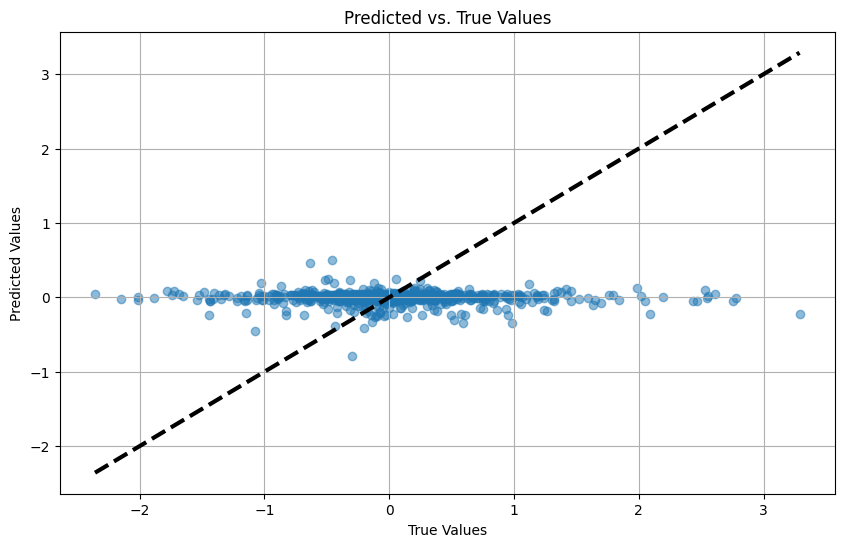

[{'batches': [{'train_loss': 0.2585054636001587, 'train_batch_size': 64}, {'train_loss': 2.2686920166015625, 'train_batch_size': 64}, {'train_loss': 1.0173578262329102, 'train_batch_size': 64}, {'train_loss': 1.6361939907073975, 'train_batch_size': 64}, {'train_loss': 1.5530595779418945, 'train_batch_size': 64}, {'train_loss': 0.45863980054855347, 'train_batch_size': 64}, {'train_loss': 1.0836224555969238, 'train_batch_size': 64}, {'train_loss': 0.6700301170349121, 'train_batch_size': 64}, {'train_loss': 0.3409739136695862, 'train_batch_size': 64}, {'train_loss': 1.0938591957092285, 'train_batch_size': 64}, {'train_loss': 1.090054988861084, 'train_batch_size': 64}, {'train_loss': 0.8535929918289185, 'train_batch_size': 64}, {'train_loss': 2.374891519546509, 'train_batch_size': 64}, {'train_loss': 2.441230058670044, 'train_batch_size': 64}, {'train_loss': 1.6098144054412842, 'train_batch_size': 64}, {'train_loss': 4.347476005554199, 'train_batch_size': 64}, {'train_loss': 2.789614439010

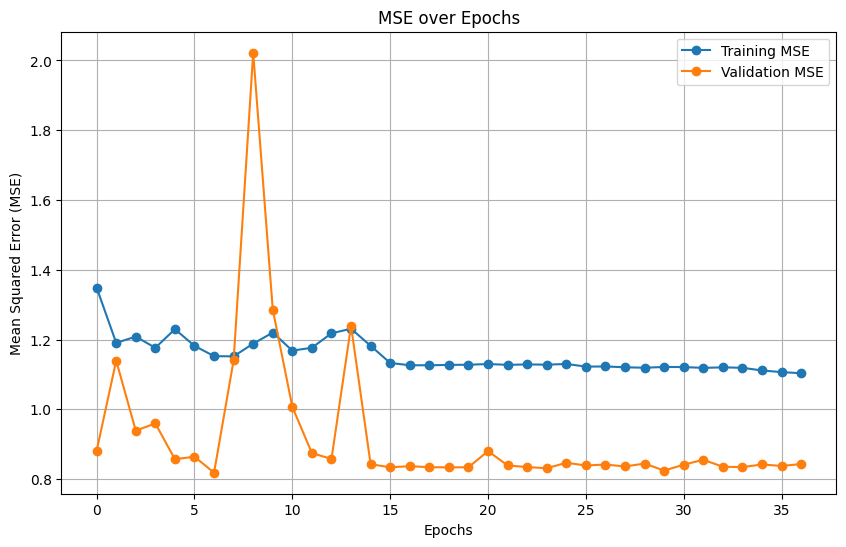


Best Hyperparameters:
batch_size: 64
hidden_size: 512
lr: 0.005757494025613979
max_epochs: 1000
nonlin: GELU(approximate='none')
num_layers: 5


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
# Evaluate the model on the test set
net = best_model

# Get predictions on the test data
y_pred_test = net.predict(X_test_seq)

# Calculate the R2 score and MSE for the test data
test_mse = mean_squared_error(y_test_seq, y_pred_test)
test_r2 = r2_score(y_test_seq, y_pred_test)

print(f"Test MSE: {test_mse:.2f}")
print(f"Test R2: {test_r2:.2f}")

# Detach tensors and convert to numpy arrays if needed
y_pred_test = y_pred_test if isinstance(y_pred_test, np.ndarray) else y_pred_test.detach().numpy()
y_test_seq = y_test_seq if isinstance(y_test_seq, np.ndarray) else y_test_seq.detach().numpy()

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_seq, y_pred_test, alpha=0.5)
plt.title('Predicted vs. True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.plot([y_test_seq.min(), y_test_seq.max()], [y_test_seq.min(), y_test_seq.max()], 'k--', lw=3)  # Line showing perfect predictions
plt.grid(True)
plt.show()

print(net.history)

history = net.history

# Extract training and validation MSE from the history
train_mse = [h['train_loss'] for h in history]
valid_mse = [h['valid_loss'] for h in history if 'valid_loss' in h]

plt.figure(figsize=(10, 6))
plt.plot(train_mse, label='Training MSE', marker='o')
plt.plot(valid_mse, label='Validation MSE', marker='o')
plt.title('MSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Print best hyperparameters again for reference
print("\n" + "="*50)
print("Best Hyperparameters:")
print("="*50)
for param, value in best_trial['result']['params'].items():
    print(f"{param}: {value}")